# Project 3 - Elliot Richardson

## Table of Contents:

I. [Problem Statement](#Problem-Statement)

II. [Data Dictionary](#Data-Used)

III. [Exploratory Analysis](#Exploratory-analysis)

IV. [Modeling](#Modeling)

V. [Model Selection](#Model-Selection)

VI. [Findings](#Findings)

## Problem Statement

For this project, I'm an analyst at a political targeting firm. In light of the pandemic, a larger share of direct voter contact is over the internet, rather than in person. However, it isn't easy to connect social media users to their voter file records and therefore their ideological support and voter turnout scores as determined by other models. So, in order to identify persuadable targets and activatable supporters, my firm wants to create a model that can differentiate between language used by people on varying ends of the political spectrum. Eventually, they will use this model to identify target accounts on platforms like Twitter to whom campaigns will conduct outreach. 

**Question I'm seeking to answer:** Do Reddit users on varying ends of the economic political spectrum use vocabularies distinct enough for a model to differentiate between them?

## Data Used

Titles and content of posts requested from [r/Socialism](https://www.reddit.com/r/DemocraticSocialism/) and [r/Capitalism](https://www.reddit.com/r/Capitalism/) using the [Pushshift API](https://pushshift.io/).

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|subreddit_s|int64|Binary indicator of the subreddit from which a post was pulled (1 = r/Socialism, 0 = r/Capitalism)|
|sentences|int64|Number of sentences in post as determined by nltk's PunktSentenceTokenizer|
|avg_sent_len|float64|Average number of words in each sentences of the post|
|words|int64|Total number of words in the post|
|avg_word_len|float64|Average number of characters in each word of the post|
|ADJ_prop|float64|Proportion of the content made up of adjectives|
|ADP_prop|float64|Proportion of the content made up of adpositions|
|ADV_prop|float64|Proportion of the content made up of adverbs|
|AUX_prop|float64|Proportion of the content made up of auxiliary words|
|CCONJ_prop|float64|Proportion of the content made up of coordinating conjunctions|
|DET_prop|float64|Proportion of the content made up of determiners|
|INTJ_prop|float64|Proportion of the content made up of interjections|
|NOUN_prop|float64|Proportion of the content made up of nouns|
|NUM_prop|float64|Proportion of the content made up of numbers|
|PART_prop|float64|Proportion of the content made up of particles|
|PRON_prop|float64|Proportion of the content made up of pronouns|
|PROPN_prop|float64|Proportion of the content made up of proper nouns|
|PUNCT_prop|float64|Proportion of the content made up of punctuation|
|SCONJ_prop|float64|Proportion of the content made up of subordinating conjunction|
|SPACE_prop|float64|Proportion of the content made up of spaces|
|SYM_prop|float64|Proportion of the content made up of symbols|
|VERB_prop|float64|Proportion of the content made up of verbs|
|X_prop|float64|Proportion of the content made up of uncategorizable words|
|vader_neg|float64|Average negativity score for the words in the post as determined by vaderSentiment's SentimentIntensityAnalyzer|
|vader_pos|float64|Average positivity score for the words in the post as determined by vaderSentiment's SentimentIntensityAnalyzer|
|vader_neu|float64|Average neutrality score for the words in the post as determined by vaderSentiment's SentimentIntensityAnalyzer|
|vader_compound|float64|Average compound score for the words in the post as determined by vaderSentiment's SentimentIntensityAnalyzer|

Check the documentation for [spaCy](https://spacy.io/api/annotation) and [vaderSentiment](https://github.com/cjhutto/vaderSentiment#resources-and-dataset-descriptions) for more information.

## Reading in data and importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import math
from datetime import datetime

from matplotlib_venn import venn2
from matplotlib.dates import date2num
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
        GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('./data/model_df.csv')
print(df.shape)
df.head()

(5847, 1224)


,subreddit_s,sentences,avg_sent_len,words,avg_word_len,ADJ_prop,ADP_prop,ADV_prop,AUX_prop,CCONJ_prop,...,wrote,www,ye,yeah,year,yolk,young,youtub,zapatista,zero
0,1,6,19.000000,114,3.466667,0.064000,0.080000,0.056000,0.072000,0.024000,...,0,0,0,0,1,0,0,1,0,0
1,1,4,7.000000,28,2.000000,0.125000,0.125000,0.000000,0.031250,0.031250,...,0,0,0,0,0,0,0,0,0,0
2,1,1,30.000000,30,5.000000,0.000000,0.100000,0.133333,0.066667,0.100000,...,0,0,0,0,0,0,0,0,0,0
3,1,15,17.466667,262,4.214286,0.071186,0.105085,0.108475,0.050847,0.020339,...,0,0,0,0,0,0,0,5,0,0
4,1,8,22.500000,180,4.458333,0.074627,0.119403,0.069652,0.034826,0.049751,...,0,0,0,0,0,0,0,0,0,0


In [3]:
nonword_cols = list(df.columns[:27])

# Exploratory analysis

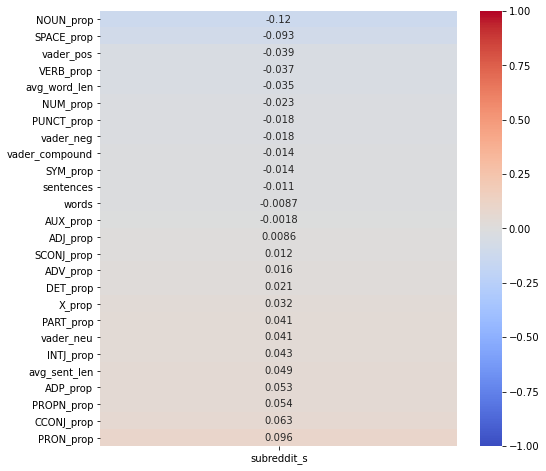

In [4]:
plt.figure(figsize=(8,8))
sns.heatmap(df[nonword_cols].corr()[['subreddit_s']].sort_values('subreddit_s')[:-1],
            vmax=1,
            vmin=-1,
            annot=True,
            cmap='coolwarm');

Okay so that isn't particularly encouraging, but hopefully the words will have stronger effects. I just couldn't fit all 1200 in the correlation heatmap!

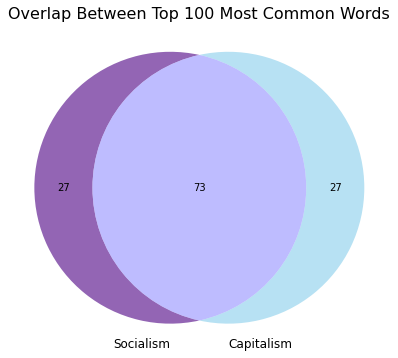

In [5]:
s_words = set(df.drop(columns=nonword_cols)[df['subreddit_s']==1].sum().sort_values(ascending=False)[:100].index)
c_words = set(df.drop(columns=nonword_cols)[df['subreddit_s']==0].sum().sort_values(ascending=False)[:100].index)

Sc = len(s_words.difference(c_words))
sC = len(c_words.difference(s_words))
SC = len(c_words.intersection(s_words))

plt.figure(figsize=(8,6))
plt.title('Overlap Between Top 100 Most Common Words',fontsize=16)
venn2(subsets = (Sc, sC, SC),
      set_labels = ('Socialism', 'Capitalism'),
      set_colors=('indigo', 'skyblue'),
      alpha = 0.6);


This is definitely a little bit intimidating! I might not have chosen subreddits with different enough vocabularies, but I wanted to do something that might actually be useful haha. We'll see how it plays out!

In [6]:
soc_mentions_in_soc = df.loc[df['subreddit_s']==1,'socialis'].sum()
soc_mentions_in_cap = df.loc[df['subreddit_s']==0,'socialis'].sum()

cap_mentions_in_soc = df.loc[df['subreddit_s']==1,'capitalis'].sum()
cap_mentions_in_cap = df.loc[df['subreddit_s']==0,'capitalis'].sum()

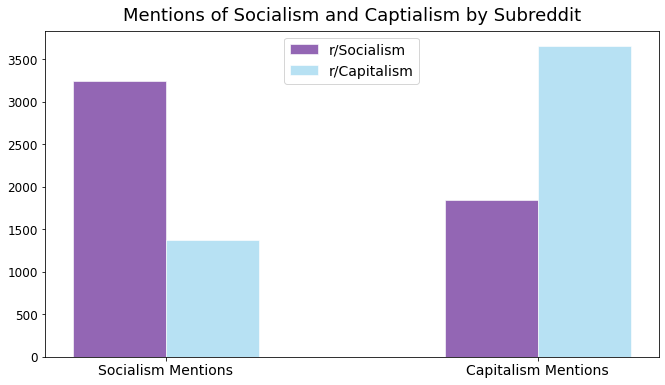

In [7]:
plt.figure(figsize=(11,6))
barWidth = 0.25

soc = [soc_mentions_in_soc, soc_mentions_in_cap]
cap = [cap_mentions_in_soc, cap_mentions_in_cap]

s = np.arange(len(soc))
c = [x + barWidth for x in s]

plt.bar(s, soc, color='indigo', width=barWidth, edgecolor='white', label='r/Socialism',alpha=0.6)
plt.bar(c, cap, color='skyblue', width=barWidth, edgecolor='white', label='r/Capitalism',alpha=0.6)
plt.xticks([r + barWidth/2 for r in range(len(soc))], ['Socialism Mentions', 'Capitalism Mentions'],fontsize=14)
plt.yticks(range(0,3501,500),fontsize=12)
plt.title('Mentions of Socialism and Captialism by Subreddit',fontsize=18,pad=10)

plt.legend(loc='upper center',fontsize=14)
plt.show()


So as one might expect, users are more likely to mention the topic of the subreddit rather than the opposing ideology. However, these subreddits often namecheck each other which also makes sense if you think about it!

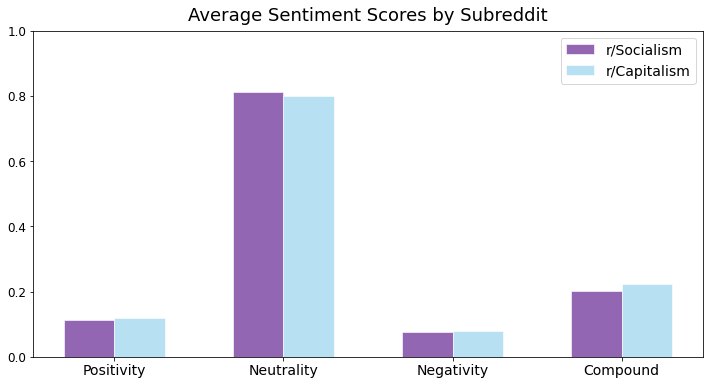

In [8]:
plt.figure(figsize=(12,6))
barWidth = 0.3

soc = [df.loc[df['subreddit_s']==1,'vader_pos'].mean(),df.loc[df['subreddit_s']==1,'vader_neu'].mean(), \
       df.loc[df['subreddit_s']==1,'vader_neg'].mean(),df.loc[df['subreddit_s']==1,'vader_compound'].mean()]
cap = [df.loc[df['subreddit_s']==0,'vader_pos'].mean(),df.loc[df['subreddit_s']==0,'vader_neu'].mean(), \
       df.loc[df['subreddit_s']==0,'vader_neg'].mean(),df.loc[df['subreddit_s']==0,'vader_compound'].mean()]

s = np.arange(len(soc))
c = [x + barWidth for x in s]

plt.bar(s, soc, color='indigo', width=barWidth, edgecolor='white', label='r/Socialism',alpha=0.6)
plt.bar(c, cap, color='skyblue', width=barWidth, edgecolor='white', label='r/Capitalism',alpha=0.6)
plt.xticks([r + barWidth/2 for r in range(len(soc))],
           ['Positivity', 'Neutrality','Negativity','Compound'],fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1],fontsize=12)
plt.title('Average Sentiment Scores by Subreddit',fontsize=18,pad=10)

plt.legend(fontsize=14)
plt.show()


Similar to some of the other charts, this isn't particularly encouraging because the scores are largely very similar. If there are any patterns here, it would be that posts in r/Capitalism are less neutral than those in r/Socialism, but only by the slightest bit. 

**Exploratory conclusions:** After charting out a few things here, I am not feeling very confident that I'll be able to make a very accurate classification model. However, the models will be much better than I am at detecting patterns in the way all of these features work together in aggregate so I have not yet lost hope!

# Modeling

Now I'm going to start modeling! I'm going to get started by establishing our features and target variable, executing a train/test split, and creating a few functions that I think will come in handy throughout this process.

In [9]:
df.dropna(inplace=True)

X = df.drop(columns='subreddit_s')
y = df['subreddit_s']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,stratify=y,random_state=26)

In [41]:
def scores(model, x = X_train, xt = X_test):
    return print('\n',
                 'Score for Training Data:', model.score(x,y_train),'\n', \
                 'Score for Testing Data:', model.score(xt,y_test))

In [45]:
def top_feats(model,coef_or_importances,top_n = None, X = X):
    if coef_or_importances == 'coef':
        f = model.coef_[0]
    else:
        f = model.feature_importances_
        
    tf_df = pd.DataFrame()
    tf_df['feat'] = X.columns
    tf_df['coef'] = [abs(coef) for coef in f]
    top_feats = tf_df.sort_values('coef',ascending=False)['feat']
    
    return list(top_feats[:top_n])

In [47]:
def feat_strengths(model,coef_or_importances,feats,output, X = X):
    if coef_or_importances == 'coef':
        f = model.coef_[0]
    else:
        f = model.feature_importances_
        
    all_feat_dict = {X.columns[i]: f[i]  for i in range(len(X.columns))}
    
    if type(feats) == list:
        feat_dict = {feat: all_feat_dict[feat] for feat in feats}
        strength_list = [all_feat_dict[feat] for feat in feats]
    else:
        feat_dict = {feat: all_feat_dict[feat]}
        strength_list = all_feat_dict[feat]
    
    if output == 'list':
        return strength_list
    else:
        return feat_dict

## Baseline accuracy

This is the score to beat!

In [13]:
list(y.value_counts(normalize=True))[0]

0.5105182144689584

## Logistic Regression

I'm going to try models out in order of increasing complexity (in my mind at least) so the first one is Logistic Regression. Simple but powerful. Let's see how it goes!

In [14]:
logr = LogisticRegression(random_state = 26)
logr.fit(X_train,y_train)
scores(logr)


 Score for Training Data: 0.8107761385503528 
 Score for Testing Data: 0.752991452991453


/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Not bad! Every parameter I added only lowered the scores so I'm keeping it extra simple for this one. It's definitely a bit overfit but it's encouraging to see the most simple model outperform the baseline by almost 50%. I'm going to capture the most important features from this model for later use!

In [15]:
logr_tf = top_feats(logr,'coef')

## K Nearest Neighbors

Now I'm going to try a KNeighborsClassifier. I performed a GridSearch to find the best parameters and then recreated that model below in order to compare test and train scores. I think this will be my workflow for the models to come!

In [16]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [17]:
knn_params = {
    'n_neighbors': [3,5,9,15],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_params, cv = 5)

knn_grid.fit(X_train_sc,y_train)
print(knn_grid.best_score_)
knn_grid.best_params_

0.5755836647013117


{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2}

In [18]:
knn = KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = 15, p = 1)

knn.fit(X_train,y_train)

scores(knn)


 Score for Training Data: 0.683557836219799 
 Score for Testing Data: 0.6153846153846154


That was significantly worse than the LogisticRegression so I'm just going to move on.

## Decision Tree

Now for decision tree!

In [19]:
dt_params = {
    'max_depth': [None, 2, 3, 4],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 3, 4, 5],
    'ccp_alpha': [0, 0.001, 0.01, 0.1]}

dt_grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 26),
                       param_grid = dt_params,
                       cv = 5,
                       verbose = 1)

dt_grid.fit(X_train,y_train)

print(dt_grid.best_score_)
dt_grid.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  7.6min finished


0.6957447780977193


{'ccp_alpha': 0.001,
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [20]:
dt = DecisionTreeClassifier(min_samples_leaf = 5,
                           min_samples_split = 10,
                           ccp_alpha = 0.001,
                           random_state = 26)

dt.fit(X_train,y_train)

scores(dt)


 Score for Training Data: 0.7825529185375241 
 Score for Testing Data: 0.6948717948717948


This one also performed worse than the LogisticRegression model so I am going to keep going. 

## Bagging classifier

Maybe bagging with help bring our scores up!

In [21]:
bag = BaggingClassifier(random_state = 26)

bag.fit(X_train, y_train)

scores(bag)


 Score for Training Data: 0.9867436390848835 
 Score for Testing Data: 0.6957264957264957


It did help a bit but we are still doing worse than the LogisticRegression model :^(

## Random Forest

In [22]:
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}

rf_grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 26),
                       param_grid = rf_params,
                       cv=5)

rf_grid.fit(X_train, y_train)

print(rf_grid.best_score_)
rf_grid.best_params_

0.7541181041181041


{'max_depth': None, 'n_estimators': 100}

In [23]:
rf = RandomForestClassifier(n_estimators = 150, random_state = 26)

rf.fit(X_train,y_train)

scores(rf)


 Score for Training Data: 0.9985033140902287 
 Score for Testing Data: 0.7384615384615385


Yay, this is our best one so far! It's only a slightly higher test score than the LogisticRegression and it's very overfit, but I'm pretty pleased. I'm going to capture the top features below for later use!

In [24]:
rf_tf = top_feats(rf,'importances')

## Extra Trees

Now for extra trees! Maybe we can do even better than the RandomForest score. However, there are a ton of hyperparameters to tune and my computer is running very slowly so I'm going to do it in two separate GridSearches which probably isn't ideal.

In [25]:
et_params = {'n_estimators': [50,100,200],
             'max_depth': [None,2,4],
             'min_samples_split': [2,4,6],
             'ccp_alpha': [0,0.001,0.01]
    
}

et_grid = GridSearchCV(estimator = ExtraTreesClassifier(random_state = 26),
                      param_grid = et_params,
                      cv = 5)

et_grid.fit(X_train,y_train)

print(et_grid.best_score_)
et_grid.best_params_

0.7718618309794781


{'ccp_alpha': 0,
 'max_depth': None,
 'min_samples_split': 6,
 'n_estimators': 200}

In [26]:
et_params = {'max_leaf_nodes': [None,20,50],
             'min_impurity_decrease': [0,0.001,0.01],
             'warm_start': [True,False],
             'bootstrap': [True,False]
    
}

et_grid = GridSearchCV(estimator = ExtraTreesClassifier(min_samples_split = 5,
                                                        n_estimators = 200,
                                                        random_state = 26),
                      param_grid = et_params,
                      cv = 5)

et_grid.fit(X_train,y_train)

print(et_grid.best_score_)
et_grid.best_params_

0.7682268385209562


{'bootstrap': False,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'warm_start': True}

In [27]:
et = ExtraTreesClassifier(min_samples_split = 5, n_estimators = 200,
                          warm_start=True, random_state = 26)

et.fit(X_train,y_train)

scores(et)


 Score for Training Data: 0.9980756895445798 
 Score for Testing Data: 0.7555555555555555


Woohoo, a new best! Maybe the separate GridSearches worked after all. Definitely capturing the top features here for later.

In [28]:
et_tf = top_feats(et,'importances')

# Boosting

## Ada Boost

I'm going to use the AdaBoost to try and boost our ExtraTrees score.

In [29]:
ada_params = {'learning_rate': [.9,1,1.1]}

ada_grid = GridSearchCV(AdaBoostClassifier(base_estimator = et), param_grid = ada_params)

ada_grid.fit(X_train,y_train)

print(ada_grid.best_score_)
ada_grid.best_params_

0.7620243155537273


{'learning_rate': 1.1}

In [30]:
ada = AdaBoostClassifier(base_estimator = et,
                        learning_rate = .9,
                         algorithm = 'SAMME',
                         random_state = 26
                    )

ada.fit(X_train,y_train)
scores(ada)


 Score for Training Data: 0.9985033140902287 
 Score for Testing Data: 0.7794871794871795


We're on a roll; another new best. As always, capturing these coefficients for later.

In [31]:
ada_tf = top_feats(ada,'importances')

## Gradient Boost

Now I'm going to compare that performance to the GradientBoost.

In [32]:
gb_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_params, cv=3)
gb_grid.fit(X_train, y_train)
print(gb_grid.best_score_)
gb_grid.best_params_

0.7506948898866795


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [33]:
gb = GradientBoostingClassifier(learning_rate = 0.08, max_depth = 4, n_estimators = 150, random_state = 26)

gb.fit(X_train,y_train)

scores(gb)


 Score for Training Data: 0.8693607013042549 
 Score for Testing Data: 0.747008547008547


One of the best testing scores but not *the* best. Probably our least overfit model though! 

In [34]:
gb_tf = top_feats(gb,'importances')

## Voting Classifier

Now I'm going to try and pool the wisdom of all 5 of our top performing models (those with 70+ testing scores) by using the VotingClassifier. I have high hopes for this one.

In [35]:
vote = VotingClassifier([
    ('rf', rf),
    ('et', et),
    ('ada', ada),
    ('gb', gb),
])

vote.fit(X_train,y_train)

scores(vote)


 Score for Training Data: 0.9980756895445798 
 Score for Testing Data: 0.7743589743589744


YAY highest testing score so far! It's definitely quite overfit so I'm going to try using the all of the captured features from earlier models to narrow down the features and recreate this VotingClassifier with a more pared down `X_train`.

Below I am retrieving the test scores for each of my five top models and using them to weight each of them in my next VotingClassifier. 

In [36]:
model_scores = [model.score(X_test,y_test) for model in [logr,rf,et,ada,gb]]
print(list(zip(['Logreg','RF','ET','ADA','GB'],model_scores)))
weights = [score/sum(model_scores) for score in model_scores]

[('Logreg', 0.752991452991453), ('RF', 0.7384615384615385), ('ET', 0.7555555555555555), ('ADA', 0.7794871794871795), ('GB', 0.747008547008547)]


Now I'm going to use those weights for another purpose as well! I'm going to slightly prioritize the strongest features from the best models as I narrow down my X columns. That's what I'm doing below with this for loop! I ended up with 800 features for my next VotingClassifier model.

In [37]:
target_num_of_feat = 1000
feats = []

for tf,weight in zip([logr_tf,rf_tf,et_tf,gb_tf,ada_tf],weights):
    feats_taken = math.ceil(target_num_of_feat * 2 * weight)
    for i in range(feats_taken):
        feats.append(tf[i])
        
lim_feats = set(feats)
len(lim_feats)

724

Because I am changing the features, I need to re-establish my X matrices and reinstantiate the models so they aren't still fit to the 1200+ features I used before.

In [38]:
X2 = df[lim_feats]

X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=.2,
                                                   stratify=y,random_state=26)

In [39]:
# reinstantiating my top performing models
logr2 = LogisticRegression()
rf2 = RandomForestClassifier(n_estimators = 150, random_state = 26)
et2 = ExtraTreesClassifier(min_samples_split = 5, n_estimators = 200,
                          warm_start=True, random_state = 26)
ada2 = AdaBoostClassifier(base_estimator = et,
                        learning_rate = .9,
                        algorithm = 'SAMME')
gb2 = GradientBoostingClassifier(learning_rate = 0.08, max_depth = 4, n_estimators = 150)

for model in [logr2,rf2,et2,ada2,gb2]:
    model.fit(X2_train,y_train)

/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now we are ready to try this VotingClassifier again! The only difference in hyperparameters this time is that I added the weights that I calculated before. They only ended up very slightly different from one another since all the scores were so close, but I thought it was a cool way to prioritize.

In [42]:
vote2 = VotingClassifier([
    ('logr',logr2),
    ('rf', rf2),
    ('et', et2),
    ('ada', ada2),
    ('gb', gb2)],
    weights = weights)
vote2.fit(X2_train,y_train)

scores(vote2, X2_train, X2_test)

/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Score for Training Data: 0.9980756895445798 
 Score for Testing Data: 0.7700854700854701


Yay that helped a bit! We went from 0.772 to 0.774 which is a small little jump but still exciting to see. I will note that I also tried this with a smaller group of features and got a lower score than before so I thought this might be the sweet spot.

# Model Selection

So my best model was a VotingClassifier that utilized the wisdom of a LogisticRegression model, a RandomForests model, an ExtraTrees model, an AdaBoost model with ExtraTrees as the base estimator, and a GradientBoost. The final testing score was 0.774, meaning we outperformed the baseline accuracy by 51.7%. I'm pretty pleased! Now I'm going to find a list of the most important features in this model to come to some findings.

In [48]:
top10s = []
lists_of_strengths = []

# using my functions created earlier to create a list of top 10 
# features and their respective strengths for each of the 5 models
for model, c_or_i in zip([logr2,rf2,et2,ada2,gb2],['coef','importances','importances','importances','importances']):
    top10 = top_feats(model, c_or_i, top_n = 10, X = X2)
    top10s.append(top10)
    strs = feat_strengths(model,c_or_i,top10,'list', X = X2)   
    lists_of_strengths.append(strs)

# gonna put them in a dataframe so I can look at them that way
feat_df = pd.DataFrame()

models = ['LogReg','RF','ET','ADA','GB']

for i in range(5):
    model = models[i]
    top10 = top10s[i]
    strs = lists_of_strengths[i]
    feat_df[model+'_coefs'] = top10
    feat_df[model+'_strengths'] = strs
    
    
feat_df.index = list(range(1,11))
feat_df

,LogReg_coefs,LogReg_strengths,RF_coefs,RF_strengths,ET_coefs,ET_strengths,ADA_coefs,ADA_strengths,GB_coefs,GB_strengths
1,comrad,1.335391,capitalis,0.057124,capitalis,0.048306,avg_word_len,0.039157,capitalis,0.199651
2,leftist,1.213206,NOUN_prop,0.023841,socialis,0.017034,capitalis,0.032423,socialis,0.096947
3,delet,-0.949231,socialis,0.022803,delet,0.008870,PROPN_prop,0.021435,comrad,0.031907
4,capitalis,-0.909674,avg_word_len,0.020469,leftist,0.008732,VERB_prop,0.016970,leftist,0.029905
5,organ,0.889227,SPACE_prop,0.019944,NOUN_prop,0.008198,delet,0.016666,NOUN_prop,0.022183
6,worker,0.873095,avg_sent_len,0.019160,comrad,0.008072,SPACE_prop,0.014435,tax,0.021388
7,ban,-0.820365,VERB_prop,0.019023,market,0.007034,socialis,0.013098,market,0.019666
8,class,0.814869,words,0.018321,PRON_prop,0.006675,NOUN_prop,0.009509,avg_sent_len,0.018557
9,debat,-0.807618,PRON_prop,0.018274,SPACE_prop,0.006206,PRON_prop,0.008213,class,0.016538
10,wage,-0.797647,PROPN_prop,0.017121,PROPN_prop,0.006087,venezuela,0.007993,SPACE_prop,0.015801


Now I'm going to create a larger list that includes all of the top 10 features from all of the models. Then I'll calculate the average coefficient for each feature across all 5 models so we can get a sense of how they generally affecetd predictions.

In [49]:
top_feat_list = []

for top10 in top10s:
    for feature in top10:
        top_feat_list.append(feature)
        
top_feat_list = list(set(top_feat_list))

In [51]:
avg_strs = []

for feat in top_feat_list:
    strs = []
    for model, c_or_i in zip([logr2,rf2,et2,ada2,gb2],
                             ['coef','importances','importances','importances','importances']):
        strength = feat_strengths(model,c_or_i,top_feat_list,'dict',X = X2)[feat]
        strs.append(strength)
        
    avg_strs.append(np.mean(strs))

Using some of the functions I created earlier, I calculated the average coefficients for each of these features and now it's time to visualize them!

In [52]:
coef_strs = pd.DataFrame()
coef_strs['coef'] = top_feat_list
coef_strs['strength'] = avg_strs

coef_strs.sort_values('strength',ascending=True,inplace=True)

colors = ['indigo' if strength > 0 else 'skyblue' for strength in coef_strs['strength']]

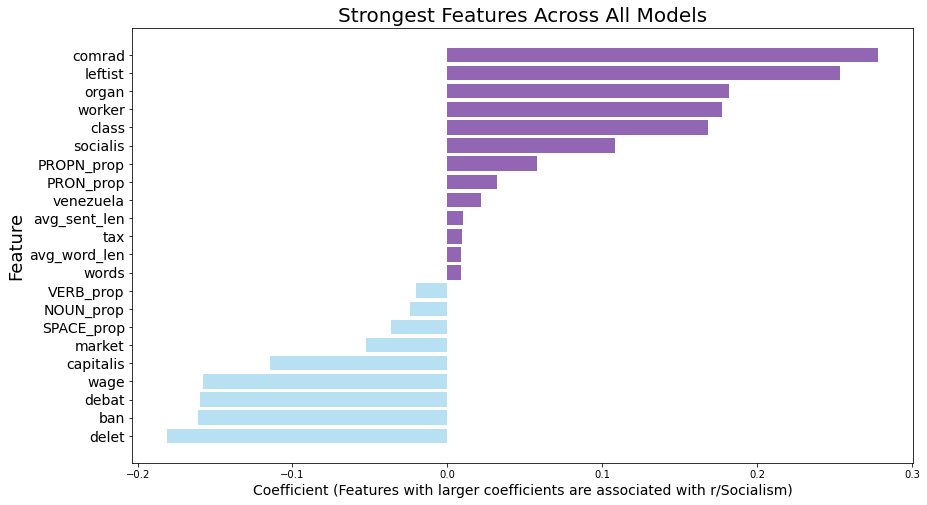

In [53]:
plt.figure(figsize=(14,8))
plt.barh(coef_strs['coef'],coef_strs['strength'],color = colors,alpha=0.6)
plt.title('Strongest Features Across All Models',fontsize=20)
plt.ylabel('Feature',fontsize=18)
plt.yticks(coef_strs['coef'],fontsize=14)
plt.xlabel('Coefficient (Features with larger coefficients are associated with r/Socialism)',fontsize=14);

Thank you for reading this far! I hope it was interesting and useful. :^)